In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pima-indians-diabetes-database/diabetes.csv


# **Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import ConfusionMatrixDisplay
from xgboost import XGBClassifier


# **Dataset Loading**

In [3]:
df = pd.read_csv('/kaggle/input/pima-indians-diabetes-database/diabetes.csv')  
print(df.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


# **Data Overview**

In [4]:
print(df.info())
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std    

# **Step 1: Data Cleaning: KNN Imputer**
> # Replacing zero values in specific columns with KNN Imputer

In [5]:
# Columns where zeros are invalid
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Replace zeros with NaN
df[cols_with_zero] = df[cols_with_zero].replace(0, np.nan)

# Apply KNN Imputer
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Check if any missing values remain
print(df_imputed.isnull().sum())


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


# **Step 4: Exploratory Data Analysis (EDA)**

# **Setting the Style For Plots**

In [6]:
# Set a cleaner style (no grid lines)
sns.set_style('white')  # Options: 'white', 'ticks'

# Set a custom, vibrant color palette
custom_colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f1c40f', '#1abc9c', '#e67e22', '#34495e']
sns.set_palette(custom_colors)

# Bigger font size for plots
sns.set_context('talk')

# 1- Class Balance

> # Check If the Dataset is Balanced or Imbalanced 

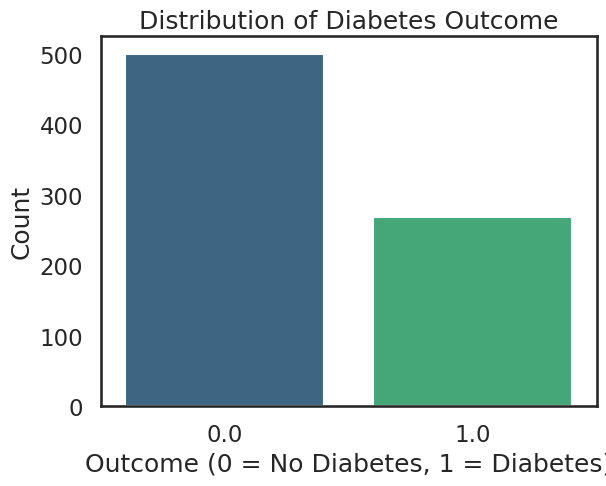

Outcome
0.0    65.104167
1.0    34.895833
Name: proportion, dtype: float64


In [7]:
# Check the distribution of target variable
sns.countplot(x='Outcome', data=df_imputed, palette='viridis')
plt.title('Distribution of Diabetes Outcome')
plt.xlabel('Outcome (0 = No Diabetes, 1 = Diabetes)')
plt.ylabel('Count')
plt.show()

# Print percentage
outcome_counts = df_imputed['Outcome'].value_counts(normalize=True) * 100
print(outcome_counts)


>  # The dataset is imbalanced, If we don’t handle it, models might favor 0 (non-diabetes) too much. So, I use stratified train/test split (to keep class balance same in both sets).

# 2- Feature Distributions

> # Check If the Features Distributions Are Skwed Or Normal 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

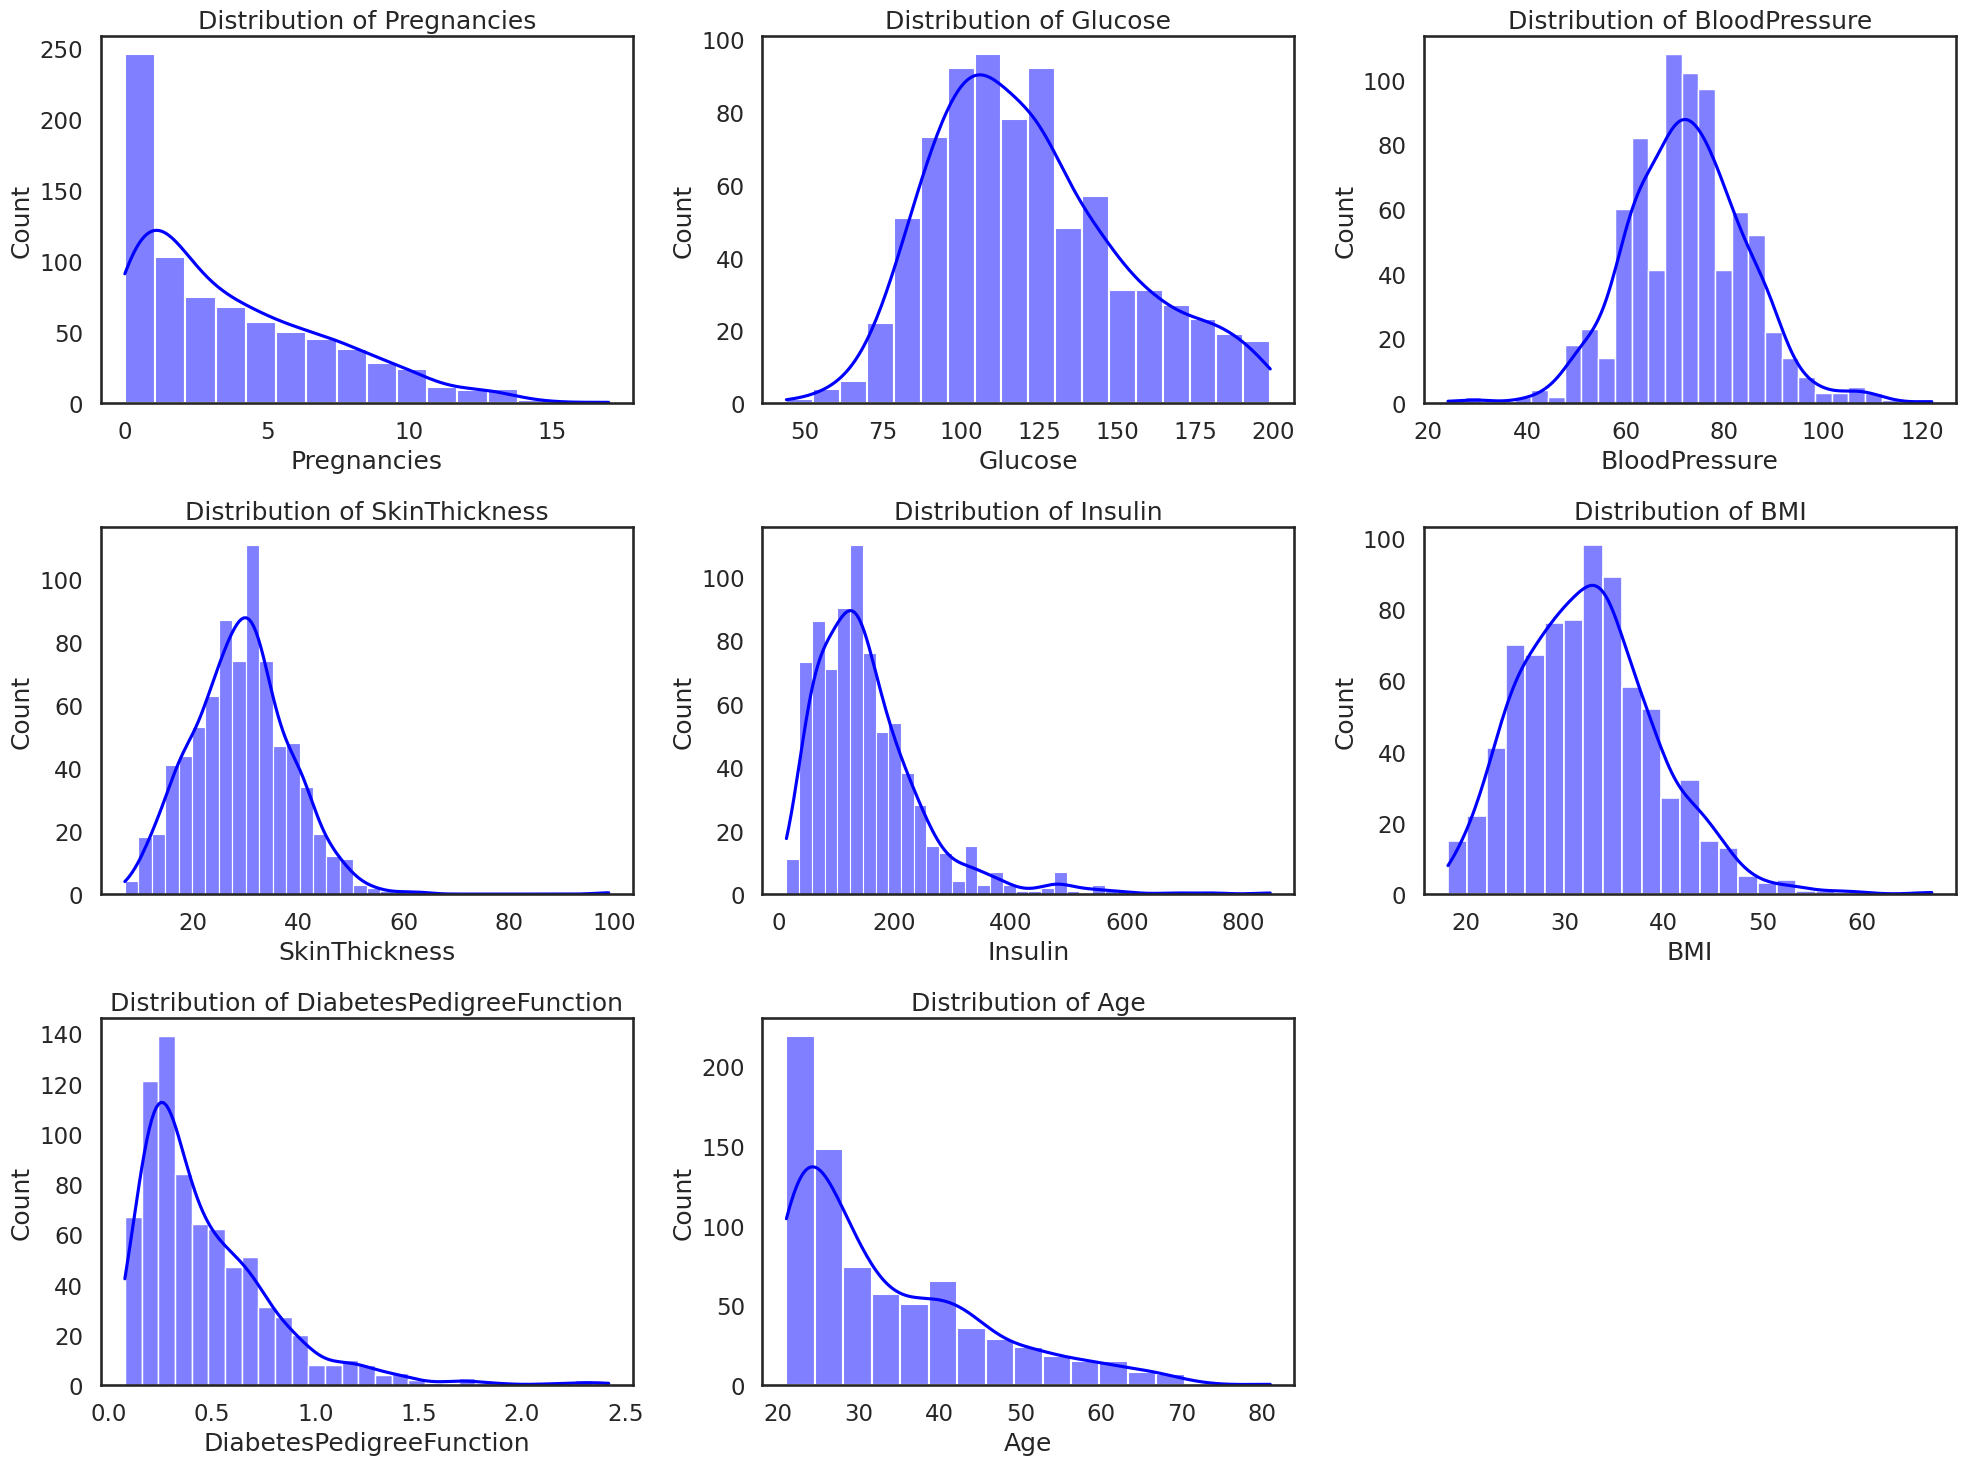

In [8]:
# List of features to plot
features = df_imputed.columns[:-1]  # All except 'Outcome'

# Plot distributions
plt.figure(figsize=(20, 15))
for i, feature in enumerate(features):
    plt.subplot(3, 3, i+1)
    sns.histplot(df_imputed[feature], kde=True, color='blue')
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

> # Features like Insulin and Pregnancies are not normally distributed, So I am going to scale the features. 

# 3- Correlation Matrix (Heatmap)

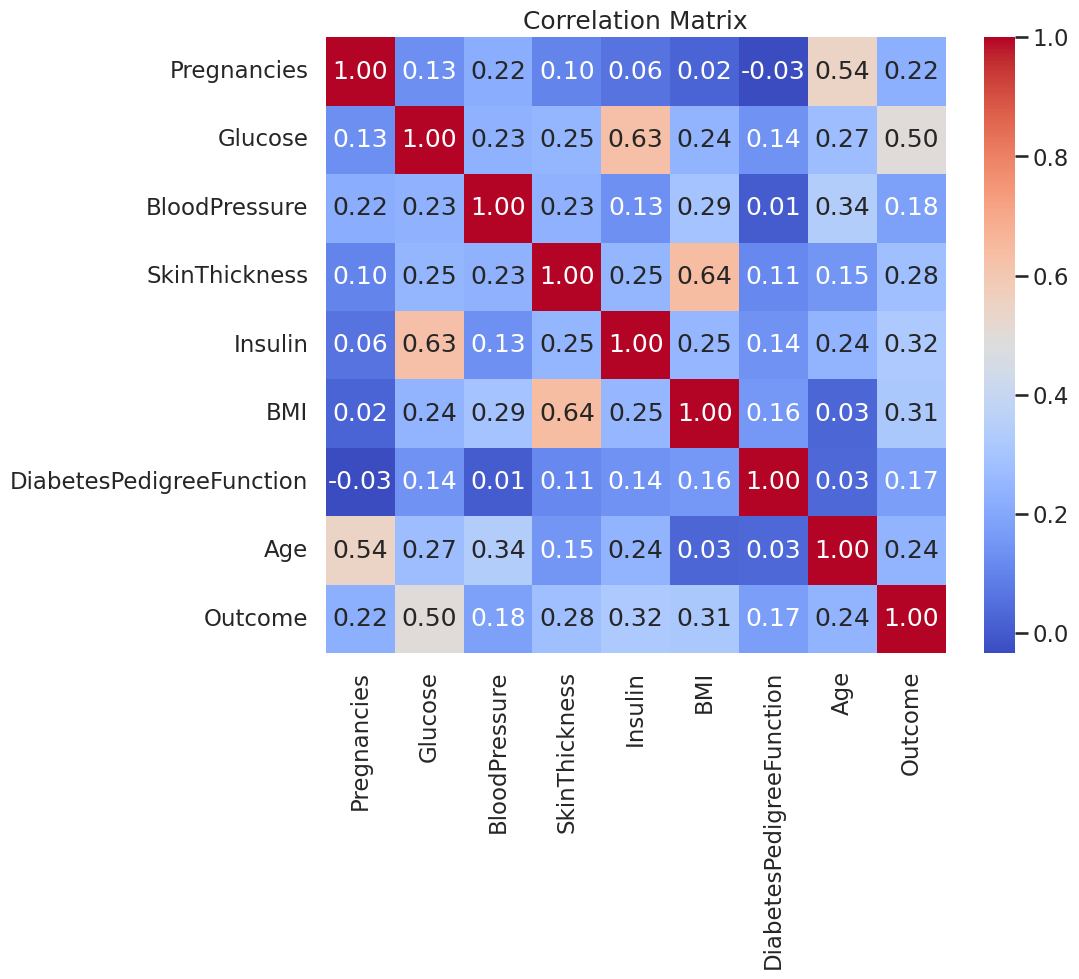

In [9]:
# Correlation Matrix
corr_matrix = df_imputed.corr()

# Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


> # Glucose is strongly correlated with diabetes, Other features like Insulin, BMI also important, but weaker. DiabetesPedigreeFunction and BloodPressure are lower, not strongly correlated individually. Glucose is a key feature, models should weigh it heavily. Features like Insulin, BMI still useful. Even features with lower correlation might still be helpful when combined.

# 4- Feature vs Target Analysis

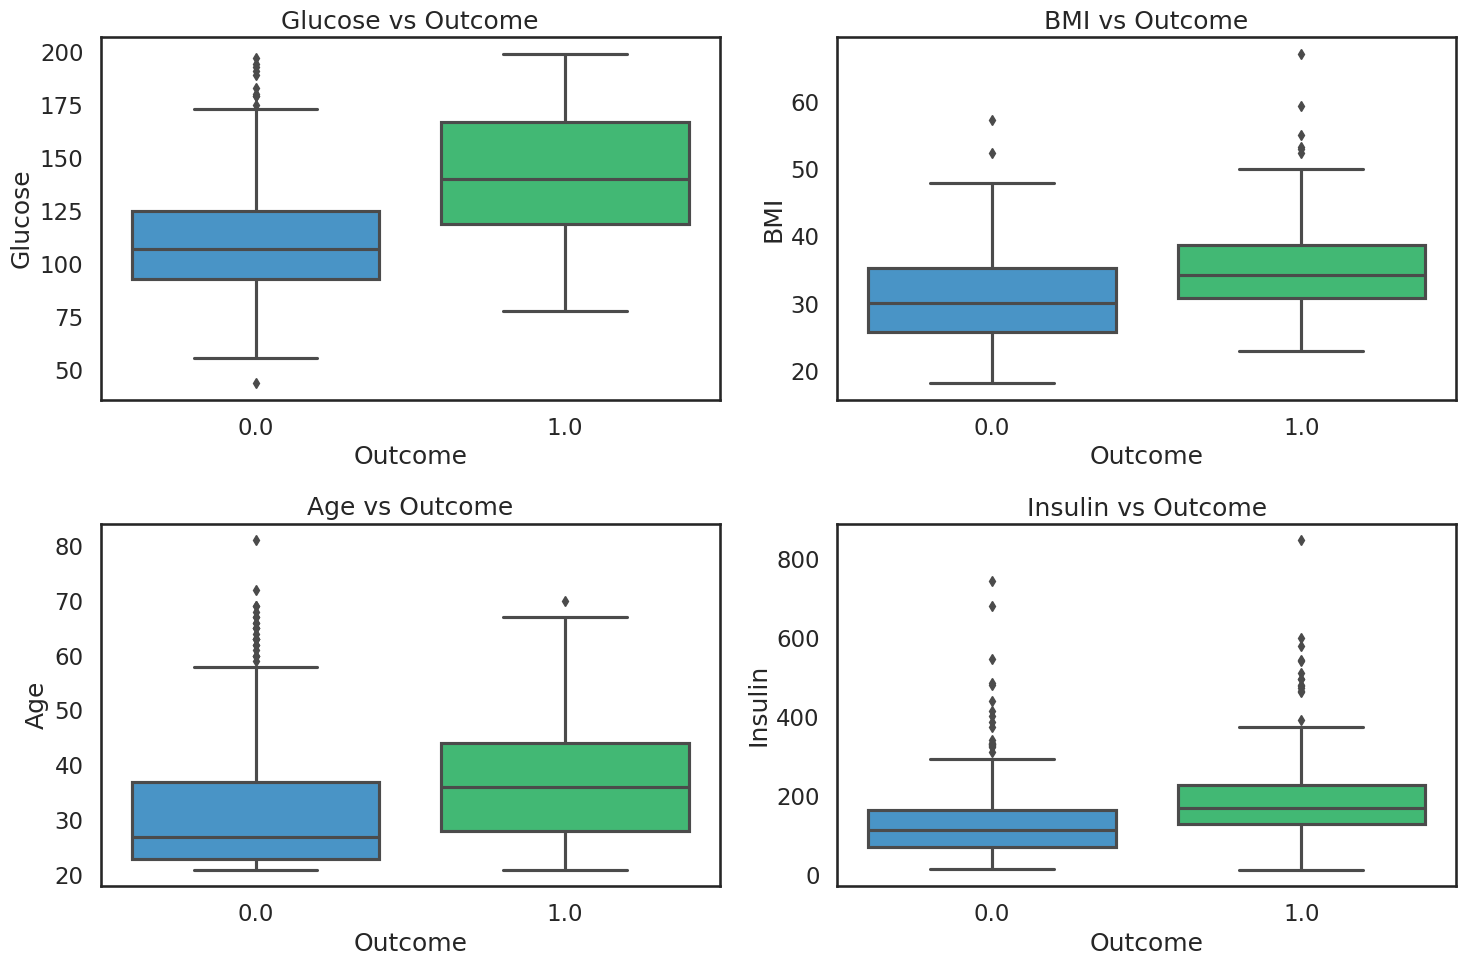

In [10]:
# Boxplots of important features vs Outcome
important_features = ['Glucose', 'BMI', 'Age', 'Insulin']

plt.figure(figsize=(15,10))
for i, feature in enumerate(important_features):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='Outcome', y=feature, data=df_imputed)
    plt.title(f'{feature} vs Outcome')
plt.tight_layout()
plt.show()


# **Step 5: Feature Engineering + Data Preparation**

> # Feature Scaling Note: Given the presence of outliers in features like Insulin and Pregnancies, RobustScaler was used for scaling. This ensures that extreme values do not distort model training. 

In [11]:
# 1. Split X and y
X = df_imputed.drop('Outcome', axis=1)
y = df_imputed['Outcome']

# 2. Train/test split (stratified because classes are imbalanced)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Apply RobustScaler
scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **Step 6: Model Fitting and Comprasion**

> # Note: Although scaling was applied manually during EDA, for the modeling stage, RobustScaler is incorporated inside pipelines to ensure a clean and leakage-free workflow." 

In [15]:
# Update models dictionary
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),  # Handling imbalance
        random_state=42
    )
}


# 2. Function to train and evaluate models
def evaluate_models(models, X_train, X_test, y_train, y_test):
    results = []
    
    for name, model in models.items():
        # Create pipeline
        pipe = Pipeline([
            ('scaler', RobustScaler()),
            ('classifier', model)
        ])
        
        # Train
        pipe.fit(X_train, y_train)
        
        # Predict
        y_pred = pipe.predict(X_test)
        y_proba = pipe.predict_proba(X_test)[:, 1]
        
        # Evaluate
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)
        
        results.append({
            "Model": name,
            "Accuracy": acc,
            "F1 Score": f1,
            "ROC AUC": roc_auc
        })
    
    return pd.DataFrame(results).sort_values(by="ROC AUC", ascending=False)

# 3. Run evaluation
results_df = evaluate_models(models, X_train, X_test, y_train, y_test)

# 4. Show results
results_df


,Model,Accuracy,F1 Score,ROC AUC
2,Random Forest,0.727273,0.580000,0.820463
0,Logistic Regression,0.733766,0.649573,0.813148
3,XGBoost,0.714286,0.584906,0.806667
1,K-Nearest Neighbors,0.727273,0.596154,0.765926


> # Model Evaluation: The Random Forest model achieved the highest ROC-AUC, indicating strong ability to separate classes. Logistic Regression showed the highest F1 Score, suggesting it balances false positives and false negatives well. Given the imbalance in the dataset, F1 Score and ROC-AUC were prioritized for model selection.

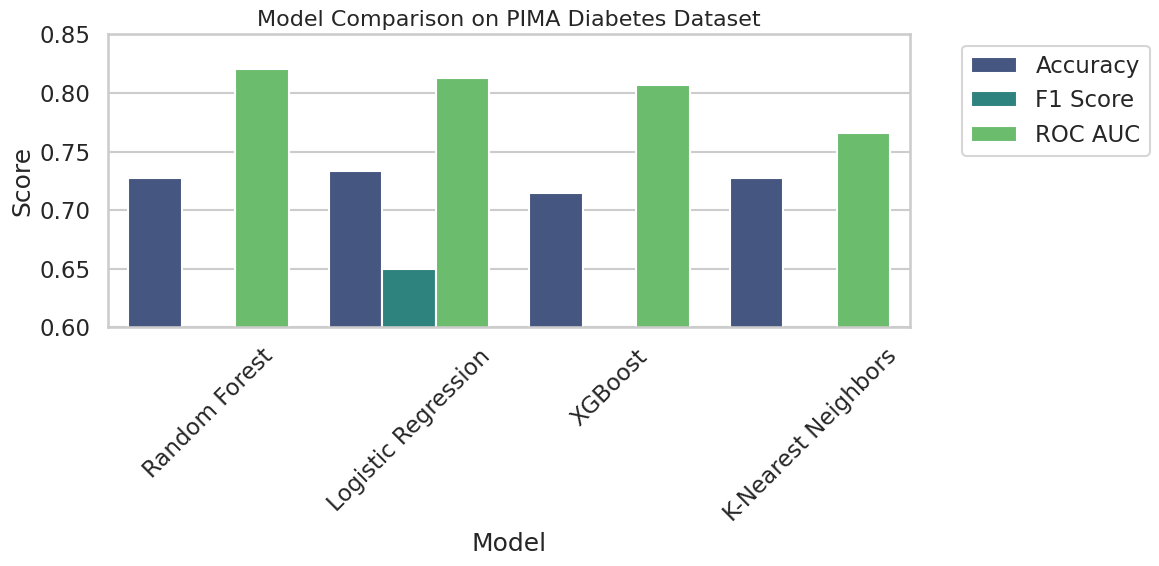

In [13]:
# Set plot style
sns.set_style("whitegrid")
plt.figure(figsize=(12,6))

# Melt the results for easier plotting
results_melted = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Plot
sns.barplot(x="Model", y="Score", hue="Metric", data=results_melted, palette="viridis")

plt.title("Model Comparison on PIMA Diabetes Dataset", fontsize=16)
plt.ylabel("Score")
plt.ylim(0.6, 0.85)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


> # After initial modeling, Logistic Regression and Random Forest showed strong performance on the PIMA Diabetes dataset, outperforming K-Nearest Neighbors and XGBoost. Due to its balance of high F1 Score and ROC-AUC, Logistic Regression will be prioritized for hyperparameter tuning.

# **Step 7: Hyperparameter Tuning (Logistic Regression)**

> # Logistic Regression was tuned using RandomizedSearchCV. The search optimized the type of regularization (penalty) and regularization strength (C) to maximize the F1 Score. The final model uses a pipeline approach to ensure scaling and modeling are cleanly connected.

In [16]:
# 1. Define the model
log_reg = LogisticRegression(class_weight='balanced', random_state=42, solver='saga', max_iter=5000)

# 2. Create Pipeline
pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', log_reg)
])

# 3. Define search space
param_distributions = {
    'classifier__penalty': ['l1', 'l2', 'elasticnet', None],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__l1_ratio': [0.0, 0.5, 1.0]  # Only used if penalty='elasticnet'
}

# 4. Setup RandomizedSearchCV
search = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions,
    n_iter=20,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# 5. Fit search
search.fit(X_train, y_train)

# 6. Best model
best_logreg_model = search.best_estimator_

# 7. Evaluate on test set
y_pred_best = best_logreg_model.predict(X_test)
y_proba_best = best_logreg_model.predict_proba(X_test)[:, 1]

# 8. Metrics
from sklearn.metrics import classification_report, roc_auc_score

print("Classification Report:\n", classification_report(y_test, y_pred_best))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_best))
print("Best Parameters:", search.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_

Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.74      0.78       100
         1.0       0.59      0.70      0.64        54

    accuracy                           0.73       154
   macro avg       0.71      0.72      0.71       154
weighted avg       0.74      0.73      0.73       154

ROC AUC Score: 0.81
Best Parameters: {'classifier__penalty': 'l2', 'classifier__l1_ratio': 1.0, 'classifier__C': 0.1}


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/l

# **Step 8: Analyze Logistic Regression Feature Importance**

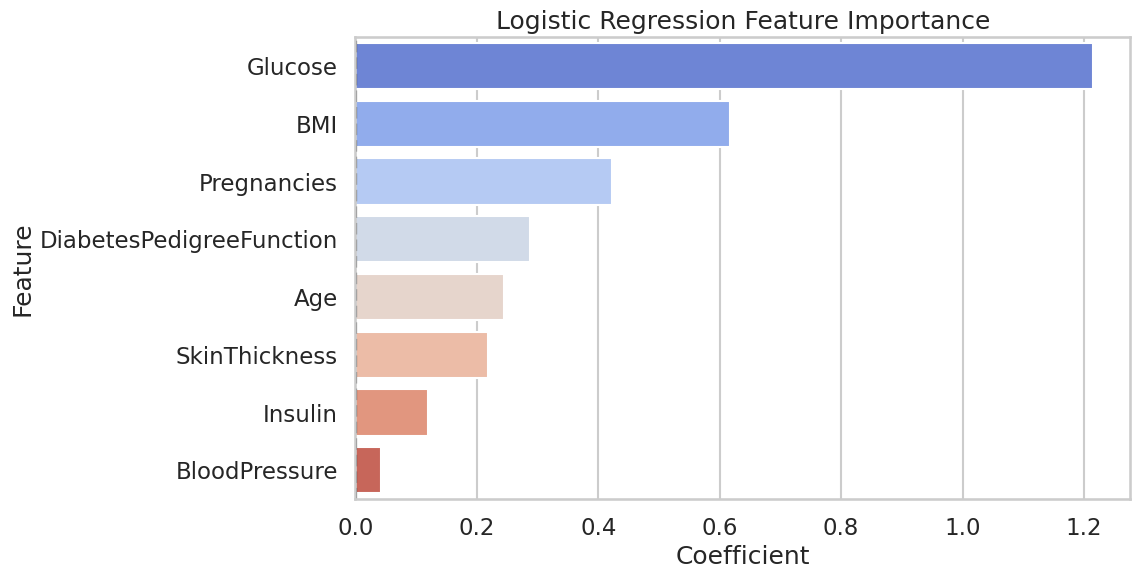

In [17]:
# 1. Get feature names
feature_names = X_train.columns

# 2. Extract the coefficients from the best model
coefficients = best_logreg_model.named_steps['classifier'].coef_[0]

# 3. Create a DataFrame
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# 4. Sort by absolute value of coefficient (importance)
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# 5. Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='coolwarm')
plt.title('Logistic Regression Feature Importance')
plt.axvline(0, color='black', linestyle='--')
plt.show()


> # Top 3 most important features influencing diabetes prediction:
> # 1- Glucose (strongest positive correlation with diabetes risk)
> # 2- BMI (Body Mass Index — obesity is a big risk factor)
> # 3- Pregnancies (more pregnancies slightly increase risk) 

# **Step 9: Random Forrest Tuning**

In [18]:
# 1. Define the pipeline
rf_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# 2. Define parameter grid
param_grid = {
    'classifier__n_estimators': randint(100, 1000),   # number of trees
    'classifier__max_depth': randint(3, 20),          # depth of each tree
    'classifier__min_samples_split': randint(2, 20),  # minimum samples to split a node
    'classifier__min_samples_leaf': randint(1, 20),   # minimum samples at a leaf node
    'classifier__max_features': ['sqrt', 'log2', None] # how features are selected
}

# 3. Set up RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    rf_pipeline, 
    param_distributions=param_grid,
    n_iter=50,  # number of combinations to try
    scoring='roc_auc',  # optimize for ROC AUC
    cv=5,  # 5-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # use all processors
)

# 4. Fit
random_search_rf.fit(X_train, y_train)

# 5. Best model
best_rf_model = random_search_rf.best_estimator_

# 6. Evaluate on test set
y_pred_rf = best_rf_model.predict(X_test)
y_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score

print("Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_rf))
print("Best Parameters:", random_search_rf.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.70      0.76       100
         1.0       0.57      0.74      0.65        54

    accuracy                           0.71       154
   macro avg       0.70      0.72      0.70       154
weighted avg       0.74      0.71      0.72       154

ROC AUC Score: 0.8198148148148148
Best Parameters: {'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 6, 'classifier__n_estimators': 561}
[CV] END classifier__C=0.001, classifier__l1_ratio=0.5, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=100, classifier__l1_ratio=0.0, classifier__penalty=elasticnet; total time=   0.0s
[CV] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__penalty=elasticnet; total time=   0.0s
[CV] END classifier__C=0.001, classifier__l1_ratio=0.0, cl

> # Random Forest models can be highly sensitive to hyperparameters. Sometimes overfitting or underfitting can happen depending on how we tune them. The optimal set of hyperparameters we found (max_depth=5, n_estimators=561, etc.) could be overly restricting the tree depth or limiting model complexity, which affects performance negatively on test data. 

In [25]:
# 1. Define the pipeline
rf_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# 2. Define broader parameter grid
param_grid = {
    'classifier__n_estimators': randint(100, 1000),   # number of trees (increased range)
    'classifier__max_depth': randint(5, 20),           # tree depth (up to 20)
    'classifier__min_samples_split': randint(2, 20),   # minimum samples to split a node
    'classifier__min_samples_leaf': randint(1, 20),    # minimum samples at a leaf node
    'classifier__max_features': ['sqrt', 'log2', None] # how features are selected
}

# 3. Set up RandomizedSearchCV with updated grid
random_search_rf = RandomizedSearchCV(
    rf_pipeline, 
    param_distributions=param_grid,
    n_iter=100,  # Number of combinations to try (increased from 50)
    scoring='roc_auc',  # Optimize for ROC AUC
    cv=5,  # 5-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all processors
)

# 4. Fit
random_search_rf.fit(X_train, y_train)

# 5. Best model
best_rf_model = random_search_rf.best_estimator_

# 6. Evaluate on test set
y_pred_rf = best_rf_model.predict(X_test)
y_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score

# 7. Print results
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_rf))
print("Best Parameters:", random_search_rf.best_params_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.70      0.76       100
         1.0       0.57      0.72      0.63        54

    accuracy                           0.71       154
   macro avg       0.69      0.71      0.70       154
weighted avg       0.73      0.71      0.71       154

ROC AUC Score: 0.8155555555555556
Best Parameters: {'classifier__max_depth': 5, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 12, 'classifier__min_samples_split': 8, 'classifier__n_estimators': 485}


In [26]:
# Define simpler RandomForest pipeline
rf_pipeline_simple = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# More restricted parameter grid
param_grid_simple = {
    'classifier__n_estimators': randint(100, 500),   # trees between 100 and 500
    'classifier__max_depth': randint(5, 15),           # max depth from 5 to 15
    'classifier__min_samples_split': randint(2, 10),   # min_samples_split between 2 and 10
    'classifier__min_samples_leaf': randint(1, 10),    # min_samples_leaf between 1 and 10
    'classifier__max_features': ['sqrt', 'log2']       # restrict feature selection to sqrt or log2
}

# Set up RandomizedSearchCV with the simpler grid
random_search_rf_simple = RandomizedSearchCV(
    rf_pipeline_simple, 
    param_distributions=param_grid_simple,
    n_iter=50,  # Reduced number of combinations
    scoring='roc_auc',  # Optimize for ROC AUC
    cv=5,  # 5-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all processors
)

# Fit model
random_search_rf_simple.fit(X_train, y_train)

# Get best model
best_rf_simple_model = random_search_rf_simple.best_estimator_

# Evaluate on test set
y_pred_rf_simple = best_rf_simple_model.predict(X_test)
y_proba_rf_simple = best_rf_simple_model.predict_proba(X_test)[:, 1]

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_rf_simple))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_rf_simple))
print("Best Parameters:", random_search_rf_simple.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.70      0.76       100
         1.0       0.57      0.72      0.63        54

    accuracy                           0.71       154
   macro avg       0.69      0.71      0.70       154
weighted avg       0.73      0.71      0.71       154

ROC AUC Score: 0.8155555555555555
Best Parameters: {'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 8, 'classifier__min_samples_split': 8, 'classifier__n_estimators': 414}


# **Step 10: Conclusion**

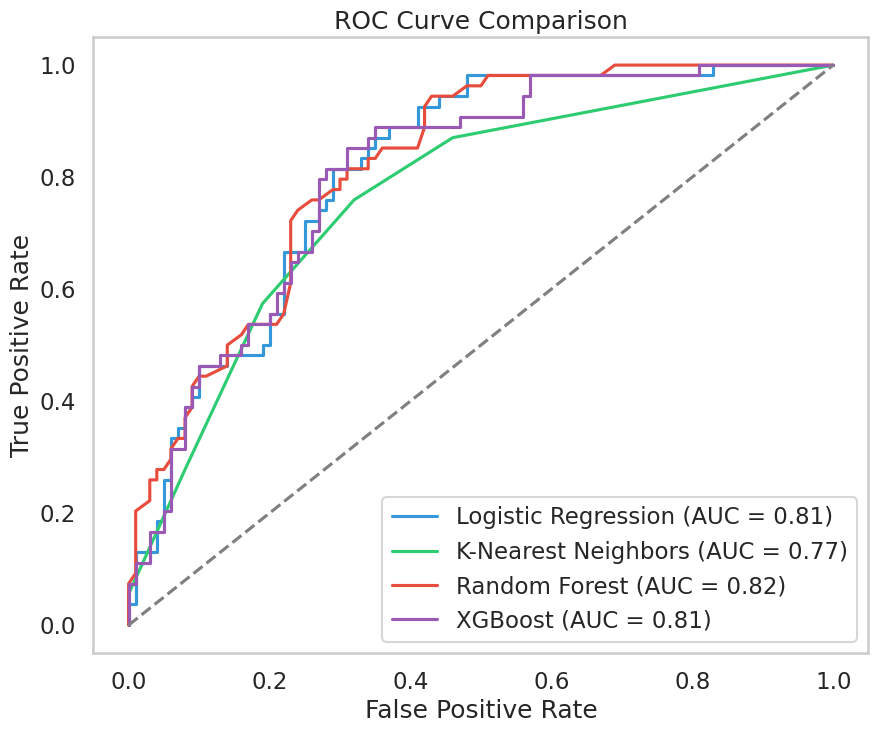

In [29]:
# Redefine models list
models_list = [
    ("Logistic Regression", LogisticRegression(class_weight='balanced', random_state=42)),
    ("K-Nearest Neighbors", KNeighborsClassifier()),
    ("Random Forest", RandomForestClassifier(class_weight='balanced', random_state=42)),
    ("XGBoost", XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
        random_state=42
    ))
]

plt.figure(figsize=(10,8))

for name, model in models_list:
    pipe = Pipeline([
        ('scaler', RobustScaler()),
        ('classifier', model)
    ])
    pipe.fit(X_train, y_train)
    
    y_proba = pipe.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot random guess line
plt.plot([0,1], [0,1], color='gray', linestyle='--')

# Label axes
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')

# Remove grid lines
plt.grid(False)

# Add legend
plt.legend(loc='lower right', frameon=True, fancybox=True)

# Show plot
plt.show()


# **Step 11: Confusion Matrix for the best model: Logistic Regression**

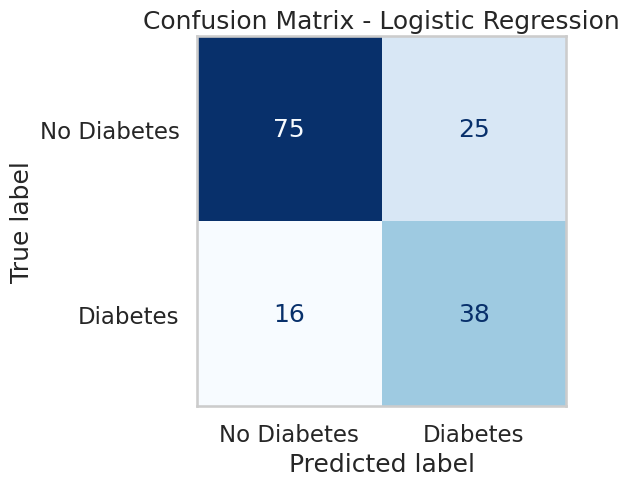

In [28]:
# Best model pipeline
best_model = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42))
])

# Fit model
best_model.fit(X_train, y_train)

# Predict
y_pred_best = best_model.predict(X_test)

# Plot confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    best_model,
    X_test,
    y_test,
    display_labels=['No Diabetes', 'Diabetes'],
    cmap=plt.cm.Blues,
    colorbar=False
)
disp.ax_.set_title("Confusion Matrix - Logistic Regression")
plt.grid(False)
plt.show()


# **Adjust the Threshold**

In [30]:
# Re-train the best model (Logistic Regression)
best_model = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42))
])
best_model.fit(X_train, y_train)

# Predict probabilities
y_proba = best_model.predict_proba(X_test)[:, 1]

# Try different thresholds
thresholds = np.arange(0.3, 0.6, 0.05)
for thresh in thresholds:
    print(f"--- Threshold: {thresh:.2f} ---")
    
    y_pred_thresh = (y_proba >= thresh).astype(int)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_thresh)
    print("Confusion Matrix:")
    print(cm)
    
    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred_thresh, digits=3))
    
    # ROC AUC (does not depend on threshold)
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"ROC AUC Score: {roc_auc:.3f}")
    print("\n")


--- Threshold: 0.30 ---
Confusion Matrix:
[[59 41]
 [ 6 48]]
Classification Report:
              precision    recall  f1-score   support

         0.0      0.908     0.590     0.715       100
         1.0      0.539     0.889     0.671        54

    accuracy                          0.695       154
   macro avg      0.724     0.739     0.693       154
weighted avg      0.779     0.695     0.700       154

ROC AUC Score: 0.813


--- Threshold: 0.35 ---
Confusion Matrix:
[[61 39]
 [ 6 48]]
Classification Report:
              precision    recall  f1-score   support

         0.0      0.910     0.610     0.731       100
         1.0      0.552     0.889     0.681        54

    accuracy                          0.708       154
   macro avg      0.731     0.749     0.706       154
weighted avg      0.785     0.708     0.713       154

ROC AUC Score: 0.813


--- Threshold: 0.40 ---
Confusion Matrix:
[[66 34]
 [ 9 45]]
Classification Report:
              precision    recall  f1-score   su

> # Threshold 0.45 seems like the sweet spot. It gives a good balance between recall (81.5%) and precision (59.5%). 

# **Final Prediction Based on Threshold 0.45**

In [35]:
# Final prediction based on threshold 0.45
threshold = 0.45
y_pred_final = (y_proba >= threshold).astype(int)

# Confusion Matrix and Classification Report
from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
print("Confusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final, digits=3))

# ROC AUC Score
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score: {roc_auc:.3f}")

Confusion Matrix:
[[70 30]
 [10 44]]

Classification Report:
              precision    recall  f1-score   support

         0.0      0.875     0.700     0.778       100
         1.0      0.595     0.815     0.688        54

    accuracy                          0.740       154
   macro avg      0.735     0.757     0.733       154
weighted avg      0.777     0.740     0.746       154


ROC AUC Score: 0.813


# **Plotting Confusion Matrix**

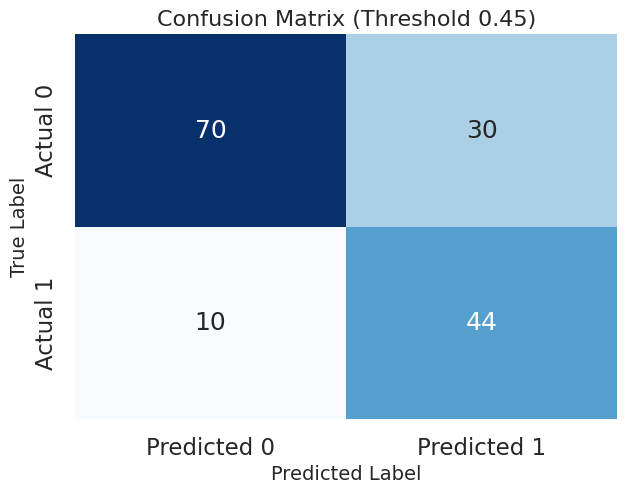

In [36]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_final)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.title('Confusion Matrix (Threshold 0.45)', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()
